In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 8 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


379 131 97 63 330


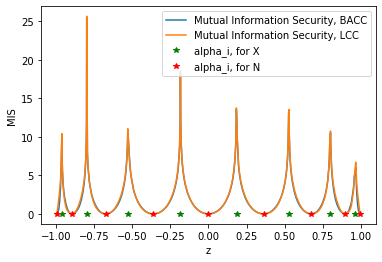

-0.9982268593512189 0.0070360032240725625
-0.9973671284528376 0.003167600841144122
-0.9967020506021051 0.001155222366684489
-0.9963725376543464 0.0005119867237835196
-0.9934324832398043 0.007884326140618922
-0.993154498780267 0.010066006922025894
-0.9915158505172119 0.02963875400326632
-0.9902780314408002 0.05335304757363819
-0.9897951918214629 0.06504834642758886
-0.9883801788973885 0.10844978045020719
-0.9882507099986602 0.11316364959886378
-0.9855537795502938 0.24514903817248698
-0.9841412386432811 0.34449629313133684
-0.9824313066322881 0.4984603072952554
-0.9811966523106395 0.6356160388077234
-0.9772107888972512 1.2539271421963885
-0.9760945804136598 1.4818595007077175
-0.9707348198543237 3.0098727992893455
-0.9702628024712043 3.1890134548309397
-0.968417284826053 3.994710234040086
-0.9657717886501611 5.622421149656146
-0.964635062845933 6.668543924664608
-0.9608966777125254 10.078295197767435
-0.9596027115300994 7.633647127232268
-0.9587639877290726 6.756196209269172
-0.957016041

0.385995375293114 0.07579347682593257
0.38827299100111556 0.09079575746262741
0.3883506918015731 0.09133289119727214
0.3884588211758331 0.09208317112501754
0.3886920435985044 0.09371253485301154
0.38953028195571693 0.09969429273497124
0.39050696188111167 0.10691307705030302
0.39420074439031527 0.1366727928927
0.3963149898002929 0.15548749173612303
0.39744053329709406 0.16604227771051444
0.4004352914751763 0.1959789033159544
0.40769657069843657 0.2801111830347237
0.411830402295025 0.33562052959542704
0.41854650376576785 0.43825142669021244
0.4188716468464375 0.4436254331875722
0.4208337807893967 0.4768750174933645
0.4213282289929292 0.48547763678346245
0.42180253417810865 0.49381537837827255
0.42610696213682875 0.5733885276129526
0.42661751609030074 0.5833030378597794
0.4283219083960188 0.6171509178292705
0.4304641966765339 0.6613616488379063
0.43515753218597397 0.7649476892683558
0.4405876080848481 0.8969945450726594
0.44204351770916506 0.9347549167350689
0.4469957795534303 1.071152130

In [3]:
K = 8
T = 9
Noise_Alloc = [0,2,4,6,8,10,12,14,16]
sigma = 1

N = 16

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [43]:
z_array_ = np.array([-0.9825, -0.9212, -0.8600, -0.7202, -0.6208, -0.4220 ])
MIS_array_ = np.zeros(len(z_array_))
for j in range(len(z_array_)):
    MIS_array_[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array_[j]], 1,sigma)

print(MIS_array_)


[0.49149718 0.49217715 0.49734595 0.49928021 0.49083609 0.49731141]
